In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/mnt/jinweilin/anaconda3/envs/kg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, vocab, max_length):
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.max_length = max_length
        self.labels = LabelEncoder().fit_transform(dataframe['label_text'])
        self.texts = [self.tokenize_and_pad(text) for text in dataframe['sentence']]

    def tokenize_and_pad(self, text):
        tokenized = self.tokenizer(text)
        indexed = [self.vocab[token] for token in tokenized]
        # Pad or truncate
        return indexed[:self.max_length] + [self.vocab['<pad>']] * (self.max_length - len(indexed))

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

In [3]:
class SentimentModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_classes, vocab):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=vocab['<pad>'])
        # 输入1维 输出64维 卷积核的高度是 3，宽度是 embedding_dim 每个卷积核覆盖三个单词
        self.conv = nn.Conv2d(1, 64, (3, embedding_dim))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # [batch_size, seq_length, embed_dim]
        x = x.unsqueeze(1)  # [batch_size, 1, seq_length, embed_dim]
        x = torch.relu(self.conv(x)).squeeze(3)  # [batch_size, num_filters, seq_length-2]
        x = torch.max(x, 2)[0]  # [batch_size, num_filters]
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [51]:
# 原设计
import torch
import torch.nn as nn
import torch.nn.functional as F

class SentimentModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_classes, vocab):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=vocab['<pad>'])
        self.conv1d = nn.Conv1d(embedding_dim, 64, 3)  # 卷积层
        self.flatten = nn.Flatten()  # 展平层
        self.fc1 = nn.Linear(64 * 38, 64)  # Adjusted input size
        self.dropout = nn.Dropout(0.4)  # Dropout层
        self.fc2 = nn.Linear(64, num_classes)  # 输出层

    def forward(self, x):
        x = self.embedding(x)  # [batch_size, seq_length, embed_dim]
        x = x.permute(0, 2, 1)  # 调整维度以适应Conv1d的输入要求 [batch_size, embed_dim, seq_length]
        x = F.relu(self.conv1d(x))  # 应用卷积和激活函数
        x = self.flatten(x)  # 展平数据
        x = self.fc1(x)  # 应用第一个全连接层
        x = self.dropout(x)  # 应用Dropout
        x = F.relu(x)  # 应用激活函数
        x = self.fc2(x)  # 应用输出层
        return F.softmax(x, dim=-1)  # 应用Softmax激活

In [4]:
# Function to evaluate the model on the test set
def evaluate(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No need to track gradients for validation
        for texts, labels in test_loader:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total * 100
    return avg_loss, accuracy

In [5]:
# 多分类问题绘制roc曲线
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

def evaluate_roc(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    y_true = []
    y_pred = []
    y_proba = []

    with torch.no_grad():
        for texts, labels in test_loader:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Collecting data for metrics
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.tolist())  # Accumulate true labels
            y_pred.extend(predicted.tolist())  # Accumulate predictions
            y_proba.extend(probabilities.tolist())  # Accumulate probabilities

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * sum([1 for true, pred in zip(y_true, y_pred) if true == pred]) / len(y_true)
    f1 = f1_score(y_true, y_pred, average='weighted')
    return avg_loss, accuracy, f1, y_true, y_proba

In [6]:
# Load your data
data = pd.read_csv('../IMDB Dataset.csv')

# Define the tokenizer and vocabulary
tokenizer = get_tokenizer('basic_english')  # Using basic English tokenizer

In [7]:
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

# Build vocabulary
vocab = build_vocab_from_iterator(yield_tokens(data['sentence']), specials=['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>'])  # Set default index for unknown words
for word, index in vocab.get_stoi().items():
    print(f'{word}: {index}')

★★: 147157
₤250: 147155
₤100: 147154
…until: 147153
…but: 147152
“you’ve: 147149
“who’s: 147147
“supreme: 147145
“sanatorium”: 147141
“professor”: 147139
“playboy”: 147138
“next”: 147135
“mr: 147134
“it’s: 147129
“if: 147128
“him”: 147127
“family”: 147123
“consider: 147119
“at: 147115
‘showdown’: 147111
‘revenge’: 147110
‘pacifist’: 147108
‘lost: 147106
‘lifer’: 147105
‘humanization’: 147104
‘enjoyable’: 147102
‘depraved’: 147100
‘condition’: 147099
‘anna: 147096
–-: 147094
þór: 147090
ýs: 147088
üvegtigris: 147085
ünfaithful: 147084
ünel: 147083
überwoman: 147082
über-spy: 147077
über-babe: 147076
ø: 147072
önsjön: 147069
ð: 147068
ïts: 147067
ïn: 147066
évery: 147062
étoile: 147061
ça: 147053
æbler: 147051
åmål: 147050
äänekoski: 147048
ääliöt: 147047
ä: 147046
âge: 147045
ángela: 147044
ánd: 147042
álvaro: 147041
¿acting: 147036
½*: 147035
º: 147034
·outdoor: 147032
·ormond: 147031
´cos: 147024
®: 147022
«very: 147020
«valuable»: 147019
«très: 147018
«truth»: 147017
«too: 147016
«th

In [8]:
# Create dataset and dataloader
dataset = SentimentDataset(data, tokenizer, vocab, max_length=40)
train_set, test_set = train_test_split(dataset, test_size=0.2)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [9]:
# Initialize the model
model = SentimentModel(len(vocab), embedding_dim=300, num_classes=3, vocab=vocab)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # 添加了权重衰减

In [ ]:
# # 训练循环
# for epoch in range(10):  # 迭代次数
#     model.train()
#     for texts, labels in train_loader:
#         # 这里需要添加文本的向量化处理，例如使用torchtext库
#         optimizer.zero_grad()
#         outputs = model(texts)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch {epoch+1}, Loss: {loss.item()}')


# # Evaluate the model on the test set after training
# test_loss, test_accuracy = evaluate(model, test_loader, criterion)
# print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')



In [10]:
# 初始化损失记录器
train_losses = []
valid_losses = []

for epoch in range(20):  # 迭代次数
    # 训练部分
    model.train()
    train_loss = 0
    for texts, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # 验证部分
    valid_loss, valid_accuracy = evaluate(model, test_loader, criterion)
    valid_losses.append(valid_loss)

    print(f'Epoch {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%')



Epoch 1, Training Loss: 0.6567, Validation Loss: 0.5739, Validation Accuracy: 69.62%
Epoch 2, Training Loss: 0.5655, Validation Loss: 0.5489, Validation Accuracy: 71.40%
Epoch 3, Training Loss: 0.5171, Validation Loss: 0.5158, Validation Accuracy: 73.66%
Epoch 4, Training Loss: 0.4766, Validation Loss: 0.5116, Validation Accuracy: 74.57%
Epoch 5, Training Loss: 0.4378, Validation Loss: 0.5248, Validation Accuracy: 74.63%
Epoch 6, Training Loss: 0.4011, Validation Loss: 0.5293, Validation Accuracy: 74.30%
Epoch 7, Training Loss: 0.3627, Validation Loss: 0.5630, Validation Accuracy: 73.70%
Epoch 8, Training Loss: 0.3277, Validation Loss: 0.5988, Validation Accuracy: 73.61%
Epoch 9, Training Loss: 0.2945, Validation Loss: 0.6452, Validation Accuracy: 73.74%
Epoch 10, Training Loss: 0.2681, Validation Loss: 0.6980, Validation Accuracy: 73.39%
Epoch 11, Training Loss: 0.2444, Validation Loss: 0.7314, Validation Accuracy: 73.51%
Epoch 12, Training Loss: 0.2223, Validation Loss: 0.7887, Valid

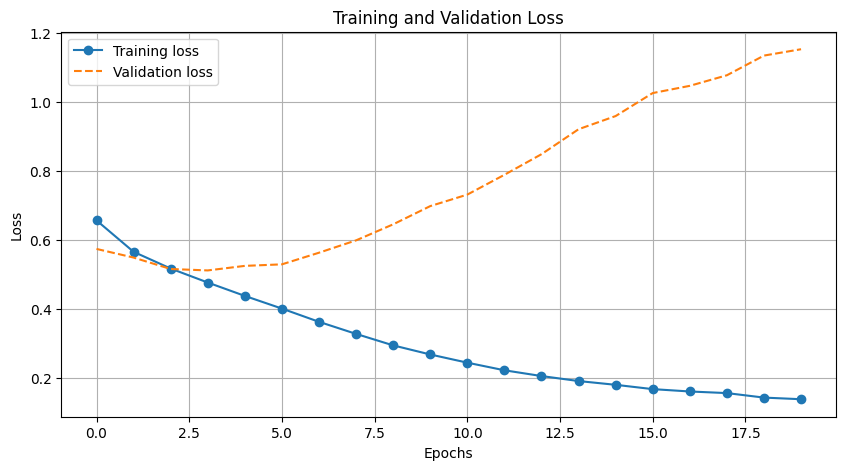

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss', marker='o')
plt.plot(valid_losses, label='Validation loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


/mnt/jinweilin/anaconda3/envs/kg/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


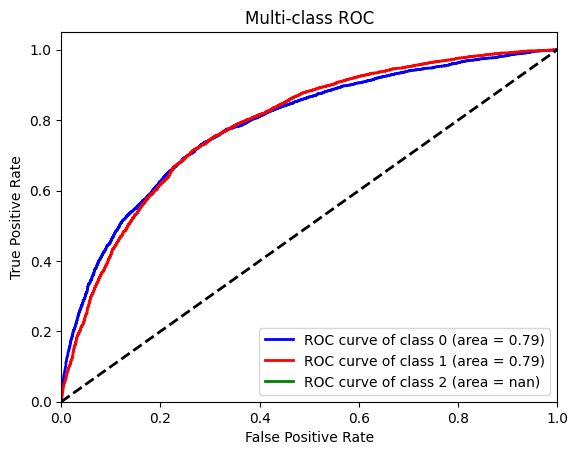

Test Loss: 1.1526, Test Accuracy: 72.26%, F1 Score: 0.7224


In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Processing after training and evaluating
test_loss, test_accuracy, f1, y_true, y_proba = evaluate_roc(model, test_loader, criterion)
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])  # Binarize labels in a one-vs-all fashion
y_proba = np.array(y_proba)

# Plotting ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, F1 Score: {f1:.4f}')